## Taller de algoritmos genéticos

Laura Catalina García González

El objetivo de este punto es generar el diseño para un módulo de Python que permita la ejecución de algoritmos genéticos a partir de diferentes operadores de selección, cruce y mutación. Para esto, el primer paso consiste en realizar un modelo de los componentes del módulo. Recuerde que el éxito de la implementación depende en su mayoría de tener un buen diseño de la estructura y las relaciones entre los
componentes. Tenga en cuenta lo siguiente:

A. El módulo debe contar con los siguientes operadores genéticos:

- Selección: torneo
- Cruce: basado en un punto
- Mutación: flit-bit
- Elitismo: incorpora automáticamente una proporción de los individuos más aptos en la siguiente generación

B. Se espera que el módulo cuente con algunas constantes predefinidas, pero parametrizables como el número de individuos en la población, el número máximo de generaciones, probabilidad de mutación, probabilidad de cruce, etc. Puede agregar las constantes que considere necesarias.

C. Sobre una población se debe ser capaz de realizar un análisis descriptivo básico sobre el fitness de los individuos utilizando los estadísticos usuales como media, varianza, máximo mínimo, etc.

D. El módulo debe contar con las siguientes opciones de visualización:

- Fitness promedio, fitness del mejor y el peor individuo de la población contra el número de generaciones. Todos en la misma gráfica.
- Diagrama de cajas del fitness de una población contra el número de generaciones

El objetivo este punto es lograr implementar el módulo a partir del diseño propuesto en el punto anterior.
Tenga en cuenta lo siguiente:

A. La eficiencia será un criterio importante en la evaluación. Problemas posteriores requerirán un cómputo
intensivo:

- Las estructuras de datos que representan los cromosomas deben utilizar arreglos de NumPy.
Recuerde que puede definir el tipo de datos utilizando el atributo dtype.
- Incorpore Numba en su implementación. Esto permitirá mejorar el tiempo de ejecución de y el uso
de memoria.

B. Recuerde que al ejecutar el algoritmo los operadores genéticos deben ser parametrizables. La
implementación realizada debe coincidir con el diseño propuesto en el punto anterior. 

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import random
from PIL import Image
import matplotlib.animation as animation
from PIL import ImageFilter

In [2]:
class GeneticAlgorithm:
    def __init__(self, num_individuals, mutation_prob, crossover_prob, elitism_rate, chromosome_length, target_fitness):
        self.num_individuals = num_individuals
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.elitism_rate = elitism_rate
        self.chromosome_length = chromosome_length
        self.target_fitness = target_fitness
        self.population = np.random.randint(2, size=(self.num_individuals, self.chromosome_length), dtype=np.int8)
        self.fitness = np.zeros(self.num_individuals, dtype=np.float32)
        self.generation = 0
    
    @staticmethod
    @njit
    def hamming_distance_fitness(population, target_array):
        # Calcula la distancia de Hamming con el objetivo
        fitness = np.array([np.sum(indiv != target_array) for indiv in population])
        return -fitness  # Negativo porque queremos minimizar la distancia

    @staticmethod
    @njit
    def evaluate_population(population):
        # Calcula el fitness como la suma de los genes (esto puede ajustarse a la función deseada)
        return np.sum(population, axis=1).astype(np.float32)
    
    # Selección por torneo

    # La selección es el proceso de elegir a los individuos que participarán en la reproducción para generar
    # la siguiente generación.

    # Se elige un subconjunto de individuos aleatoriamente de la población (en este caso, dos individuos).
    # Dentro de este grupo, el individuo con el mejor fitness (valor más alto en este caso) es seleccionado.
    # Este proceso se repite hasta llenar el número de padres necesarios.
    @staticmethod
    @njit
    def tournament_selection(population, fitness, tournament_size=2):
        # Selección por torneo: selecciona un subconjunto y elige el más apto
        num_individuals = population.shape[0]
        parents = np.empty_like(population)
        for i in range(num_individuals):
            candidates_idx = np.random.choice(num_individuals, tournament_size, replace=False)
            winner_idx = candidates_idx[np.argmax(fitness[candidates_idx])]
            parents[i] = population[winner_idx]
        return parents

    # Cruce en un punto

    #  El cruce es el proceso de combinar dos individuos (padres) para generar nuevos individuos (hijos)
    #  manteniendo la variabilidad genética en la población. 

    # Los padres se seleccionan en parejas.
    # Se elige aleatoriamente un punto de corte en el cromosoma.
    # Los genes de los padres se mezclan desde ese punto. Por ejemplo, los genes antes del punto se toman 
    # del primer padre, y los genes después del punto del segundo padre, y viceversa para el otro hijo.
    @staticmethod
    @njit
    def one_point_crossover(parents, crossover_prob):
        # Cruce de un punto
        num_individuals, chromosome_length = parents.shape
        offspring = np.empty_like(parents)
        for i in range(0, num_individuals, 2):
            parent1, parent2 = parents[i], parents[i+1]
            if np.random.rand() < crossover_prob:
                crossover_point = np.random.randint(1, chromosome_length)
                offspring[i, :crossover_point] = parent1[:crossover_point]
                offspring[i, crossover_point:] = parent2[crossover_point:]
                offspring[i+1, :crossover_point] = parent2[:crossover_point]
                offspring[i+1, crossover_point:] = parent1[crossover_point:]
            else:
                offspring[i], offspring[i+1] = parent1, parent2
        return offspring

    # Mutación Flip-Bit
    
    # La mutación es un operador que introduce cambios menores en los individuos, ayudando a evitar la convergencia
    # prematura y explorando nuevas áreas del espacio de soluciones. 

    # Cada bit en el cromosoma de cada individuo tiene una probabilidad de mutación (dada como mutation_prob).
    # Si un bit es seleccionado para mutación, su valor se invierte. Por ejemplo, si era 1, cambia a 0, y viceversa.
    @staticmethod
    @njit
    def flip_bit_mutation(offspring, mutation_prob):
        # Mutación de flip-bit
        num_individuals, chromosome_length = offspring.shape
        for i in range(num_individuals):
            for j in range(chromosome_length):
                if np.random.rand() < mutation_prob:
                    offspring[i, j] = 1 - offspring[i, j]  # Flip bit
        return offspring

    # Elitismo 

    # El elitismo es una estrategia para preservar los mejores individuos de una generación, asegurando que la calidad
    # general de la población no disminuya en las sucesivas generaciones.

    # Se determina un porcentaje de los individuos con el mayor fitness, que representan la élite de la población.
    # Estos individuos se copian directamente a la siguiente generación sin cambios.

    def apply_elitism(self, offspring):
        # Aplicación de elitismo: preserva los mejores individuos
        num_elites = int(self.elitism_rate * self.num_individuals)
        elite_indices = np.argsort(self.fitness)[-num_elites:]
        elites = self.population[elite_indices]
        offspring[:num_elites] = elites
        return offspring
    
    def run(self, stats):
        # Ciclo principal de generaciones
        self.generation = 0
        no_improvement_counter = 0
        max_generations_without_improvement = 50
        best_fitness_previous = 0

        while True:
            # Evaluar población
            self.fitness = self.evaluate_population(self.population)
            parents = self.tournament_selection(self.population, self.fitness)
            offspring = self.one_point_crossover(parents, self.crossover_prob)
            offspring = self.flip_bit_mutation(offspring, self.mutation_prob)
            offspring = self.apply_elitism(offspring)
            
            self.population = offspring
            self.fitness = self.evaluate_population(self.population)

            stats.record_statistics(self.fitness)

            # Encuentra el índice del mejor individuo y su fitness
            best_fitness = np.max(self.fitness)
            best_individual = self.population[np.argmax(self.fitness)]
            self.generation += 1

            # Condición de convergencia si el fitness objetivo se alcanzó
            if best_fitness == self.target_fitness:
                print(f"Objetivo de fitness alcanzado en generación {self.generation}")
                break

            # Comprobar estabilidad del fitness
            if best_fitness == best_fitness_previous:
                no_improvement_counter += 1
            else:
                no_improvement_counter = 0  # Reset if fitness improves
            best_fitness_previous = best_fitness

            # Si no hubo mejora en 30 generaciones, detener
            if no_improvement_counter >= max_generations_without_improvement:
                print(f"Fitness estable durante {max_generations_without_improvement} generaciones. Deteniendo en generación {self.generation}")
                break

    def runI(self, stats, frames, target_array, resize_shape):
        self.generation = 0
        while True:
            self.fitness = self.hamming_distance_fitness(self.population, target_array)
            parents = self.tournament_selection(self.population, self.fitness)
            offspring = self.one_point_crossover(parents, self.crossover_prob)
            offspring = self.flip_bit_mutation(offspring, self.mutation_prob)
            offspring = self.apply_elitism(offspring)
            self.population = offspring
            self.fitness = self.hamming_distance_fitness(self.population, target_array)
            stats.record_statistics(self.fitness)

            # Guardar el mejor individuo para el GIF
            best_individual = self.population[np.argmax(self.fitness)]
            frames.append(best_individual.reshape(resize_shape))

            self.generation += 1

            if np.max(self.fitness) == self.target_fitness or self.generation >= 7000:
                print(f"Generación {self.generation}: Objetivo alcanzado o límite de generación.")
                break
            
            
class Statistics:
    def __init__(self):
        self.fitness_history_full = []  # Almacenará los valores completos de fitness

    def record_statistics(self, fitness):
        # Guardar la distribución completa de fitness para la generación
        self.fitness_history_full.append(fitness.copy())

    def visualize_statistics(self):
        # Extraer datos para el gráfico de línea (promedio, máximo, mínimo)
        generations = range(len(self.fitness_history_full))
        mean_fitness = [np.mean(fitness) for fitness in self.fitness_history_full]
        max_fitness = [np.max(fitness) for fitness in self.fitness_history_full]
        min_fitness = [np.min(fitness) for fitness in self.fitness_history_full]

        # Gráfico de evolución de fitness promedio, máximo y mínimo
        plt.plot(generations, mean_fitness, label='Fitness Promedio')
        plt.plot(generations, max_fitness, label='Mejor Fitness')
        plt.plot(generations, min_fitness, label='Peor Fitness')
        plt.xlabel('Generaciones')
        plt.ylabel('Fitness')
        plt.title('Evolución del Fitness')
        plt.legend()
        plt.show()

        # Diagrama de cajas del fitness en función de primedio de generaciones
        interval = 100  # por ejemplo, cada 5 generaciones
        averaged_fitness_history = [
            np.mean(self.fitness_history_full[i:i + interval], axis=0)
            for i in range(0, len(self.fitness_history_full), interval)
        ]
        avg_generations = generations[::interval]

        plt.figure(figsize=(20, 6))
        plt.boxplot(averaged_fitness_history, positions=avg_generations, showfliers=False)
        plt.xticks(rotation=45)
        plt.xlabel('Generaciones')
        plt.ylabel('Fitness')
        plt.title('Distribución de Fitness Promedio en Intervalos de Generaciones')
        plt.show()



El objetivo de este punto es verificar la implementación realizada anteriormente. Para esto se considerará
el siguiente problema. Suponga que se tiene una población formada por individuos representados por un
arreglo de tamaño N con únicamente ceros y unos. El nivel de fitness de un individuo se define como la suma
de todos los elementos en el arreglo. Por lo tanto, el mejor individuo (o el valor óptimo para el problema)
será aquel que cuya representación es un arreglo formado únicamente por unos. Este problema, aunque
trivial, servirá para evaluar la lógica subyacente de los algoritmos genéticos. La idea es comenzar con una
población de individuos generados de manera aleatoria en los cuales cada individuo se representa con un
arreglo de ceros y unos. Luego, al aplicar el algoritmo genético y producir nuevas poblaciones, se espera
encontrar la solución óptima al problema. Para desarrollar este punto tenga en cuenta lo siguiente:

A. Defina una población formada por individuos que representan como un arreglo binario de tamaño N.
Puede generar los arreglos de manera aleatoria dando la misma probabilidad de tener 0 o 1 en cada
posición del arreglo.

B. Realice pruebas con valores de N suficientemente grandes y con diferentes valores de probabilidad al
generar la población inicial. Por ejemplo, con individuos que tengan en promedio únicamente el 10% de
unos.

C. Prepare una serie de experimentos donde implemente diferentes versiones del algoritmo variando los
operadores genéticos.

D. Genere un reporte de los hallazgos encontrados al comparar el desempeño de los diferentes operadores
genéticos. ¿Cuál sería su recomendación específicamente para este problema?


In [3]:
# Función para inicializar la población con una probabilidad específica de unos
def initialize_population(num_individuals, chromosome_length, one_probability):
    return np.random.choice([0, 1], size=(num_individuals, chromosome_length), p=[1 - one_probability, one_probability])

Objetivo de fitness alcanzado en generación 71
Visualizando: N=100, P(1)=0.3, Mut=0.02, Cross=0.9, Elite=0.05


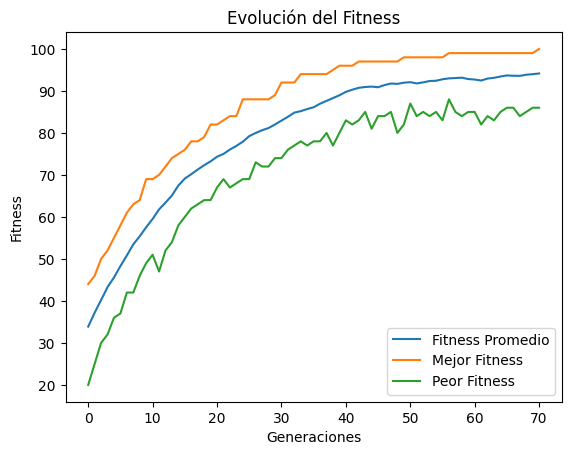

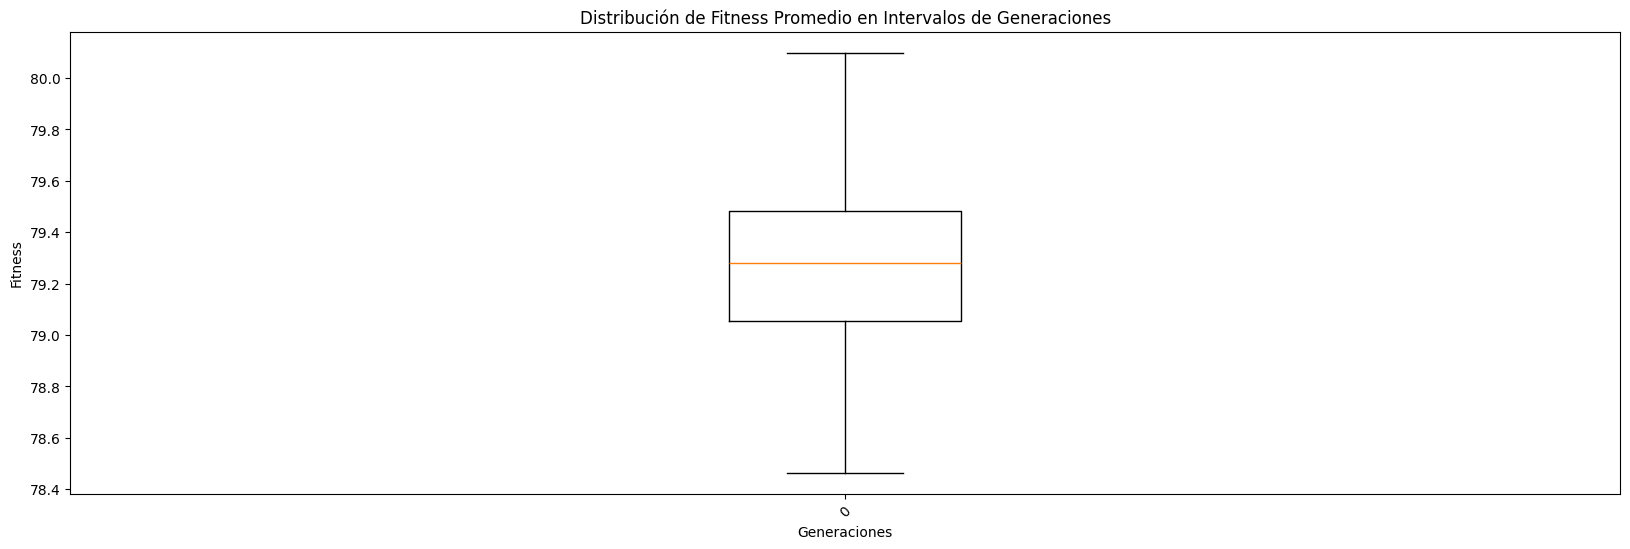

Experimento completo: N=100, P(1)=0.3, Mut=0.02, Cross=0.9, Elite=0.05


In [4]:
# Configuración y ejecución de los experimentos con visualización
def run_experiments():
    N_values = [100]  # Tamaños del cromosoma
    one_probabilities = [0.3]  # Probabilidades iniciales de unos
    mutation_probs = [0.02]  # Diferentes probabilidades de mutación
    crossover_probs = [0.9]  # Probabilidades de cruce
    elitism_rates = [0.05]  # Diferentes tasas de elitismo
    
    # Resultados acumulados
    results = []
    
    for N in N_values:
        for one_prob in one_probabilities:
            for mutation_prob in mutation_probs:
                for crossover_prob in crossover_probs:
                    for elitism_rate in elitism_rates:

                        num_individuals=200

                        # Inicializar el GA con una población inicial configurada
                        population = initialize_population(num_individuals, chromosome_length=N, one_probability=one_prob)
                        
                        ga = GeneticAlgorithm(
                            num_individuals=num_individuals,
                            mutation_prob=mutation_prob,
                            crossover_prob=crossover_prob,
                            elitism_rate=elitism_rate,
                            chromosome_length=N,
                            target_fitness= N  # Fitness deseado para detener
                        )

                        # Reemplazamos la población inicial por la generada con la probabilidad específica
                        ga.population = population
                        
                        # Registrar estadísticas
                        stats = Statistics()
                        #for gen in range(ga.max_generations):
                        #    ga.run()
                        #    stats.record_statistics(ga.fitness)
                        ga.run(stats)
                        
                        # Visualizar estadísticas al final de cada experimento
                        print(f"Visualizando: N={N}, P(1)={one_prob}, Mut={mutation_prob}, Cross={crossover_prob}, Elite={elitism_rate}")
                        stats.visualize_statistics()  # Visualización de la evolución del fitness
                        
                        # Almacena los resultados
                        results.append({
                            'chromosome_length': N,
                            'initial_one_prob': one_prob,
                            'mutation_prob': mutation_prob,
                            'crossover_prob': crossover_prob,
                            'elitism_rate': elitism_rate,
                            'fitness_history': stats.fitness_history_full,
                            'generations': ga.generation

                        })
                        
                        print(f"Experimento completo: N={N}, P(1)={one_prob}, Mut={mutation_prob}, Cross={crossover_prob}, Elite={elitism_rate}")
    
    return results

# Ejecutar los experimentos y guardar los resultados
experiment_results = run_experiments()

## CON LETRA DE LA INICIAL DE MI NOMBRE

In [5]:
letra = [[0,1,1],
        [0,1,1],
        [0,1,1],
        [0,0,0]]

# Convertimos la letra a un arreglo unidimensional para la comparación de Hamming
target_array = np.array(letra).flatten()

target_array.shape

(12,)

In [6]:
def create_gif(frames):
    fig, ax = plt.subplots()
    ims = []
    for frame in frames:
        im = ax.imshow(frame, cmap='gray', animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True)
    ani.save("evolucion.gif", writer="imagemagick")


Generación 35: Objetivo alcanzado o límite de generación.


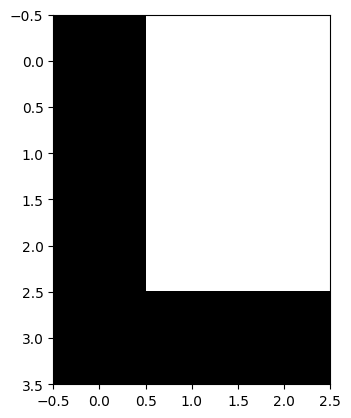

In [7]:
# Configuración de ejecución
ga = GeneticAlgorithm(num_individuals=12, mutation_prob=0.01, crossover_prob=0.9,
                    elitism_rate=0.1, chromosome_length=12, target_fitness=0)

stats = Statistics()
frames = []
shape = (4,3)
ga.runI(stats, frames, target_array, shape)
create_gif(frames)

In [8]:
#gif_path = 'C:/Users/Laura/Downloads/evolucion.gif'

# Cargar la imagen GIF
#gif = Image.open(gif_path)

# Número total de cuadros en el GIF
#num_frames = gif.n_frames

# Mostrar cada cuadro del GIF solo una vez
#for frame in range(num_frames):
#    gif.seek(frame)  # Mueve al cuadro actual
#    plt.imshow(gif)  # Muestra el cuadro
#    plt.axis('off')  # Opcional: oculta los ejes
#    plt.pause(0.1)  # Ajusta la velocidad de reproducción (0.1 segundos por cuadro)

#plt.show()  # Muestra el GIF completo una sola vezgif_path = 'ruta_del_gif.gif'


## CON FIRMA

In [9]:
def leerImagen():
    image = Image.open('/home/laura/Descargas/firma_laura2.jpeg')
    print(image.size)
    image = image.resize((150, 150))  # Ajusta el tamaño según lo necesites
    # Display the image (optional)
    plt.figure()
    plt.imshow(image)
    plt.axis('off') # Hide axes
    plt.show()

    # Convert the image to a NumPy array (if needed)
    image_array = np.array(image)
    return image_array, image


In [10]:
def convertirBlancoNegro(image):
    # Convert image to grayscale
    image = image.convert('L')
    # Binarize the image (convert to black and white)
    threshold = 128  # Adjust this value as needed
    image = image.point(lambda p: p > threshold and 1 or 0)

    # Display the binarized image
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

    # Convert the image to a NumPy array
    image_array = np.array(image)
    print(image_array.shape)
    return image_array

(1269, 823)


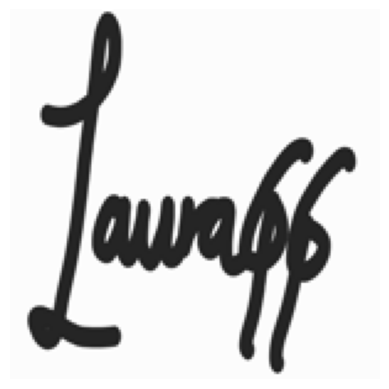

(150, 150, 3)


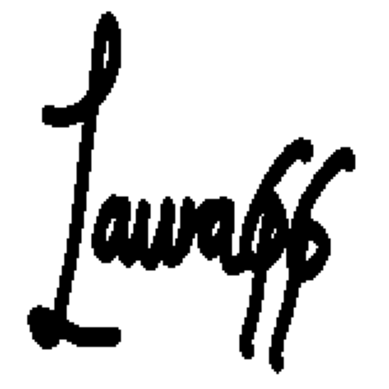

(150, 150)


In [11]:
image_array , image = leerImagen()
print(image_array.shape)
image_array = convertirBlancoNegro(image)

In [12]:
target_array = np.array(image_array).flatten()

In [13]:
target_array.size

22500

In [14]:
def create_gif(frames, interval=200, n_frames_to_save=15):
    fig, ax = plt.subplots()
    ims = []
    
    # Selecciona solo algunos frames
    selected_frames = frames[::n_frames_to_save]
    
    for frame in selected_frames:
        im = ax.imshow(frame, cmap='gray', animated=True)
        ims.append([im])
        
    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True)
    ani.save("firma.gif", writer="imagemagick")


In [15]:
# Configuración de ejecución para el algoritmo genético con imagen procesada
ga = GeneticAlgorithm(num_individuals=10, mutation_prob=0.0001, crossover_prob=0.9,
                      elitism_rate=0.1, chromosome_length=target_array.size, target_fitness=0)

stats = Statistics()
frames = []
ga.runI(stats, frames, target_array, image_array.shape)

# Crear GIF con los parámetros ajustados
create_gif(frames, interval=200, n_frames_to_save=500)